# Data Analysis

## Overview
We used SQLite to store all information of tripdata and stations. By pre-processing, we have splitted the data into two parts - the tripdata and stations - to remove redundancy. The screenshots below are the structures of two tables for the two parts of data.

![Data structure of stations](pics/p1.png)

![Data structure of trips](pics/p2.png)

Then we plot graphs using matplot and calculate results using python.

## Formatting Station Information

In [49]:
import sqlalchemy
import csv
import json
import statistics
import datetime
import pandas

from models.tripdata import tripdata
from tools.database import Database
from models.station import station

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

session = Database().getSession()

In [ ]:
f = open('rawdata.csv', 'r')
reader = csv.DictReader(f)
trips = []
stations = {}
for line in reader:
    trips.append(line)
for trip in trips:
    stations[int(trip['start station id'])] = {
        'station_name': trip['start station name'],
        'latitude': trip['start station latitude'],
        'longitude': trip['start station longitude']
    }
    stations[int(trip['end station id'])] = {
        'station_name': trip['end station name'],
        'latitude': trip['end station latitude'],
        'longitude': trip['end station longitude']
    }
sorted_stations = (sorted(stations.items(), key=lambda item: item[0]))

session = Database().getSession()
for a in sorted_stations:
    nStation = station(
        id=a[0],
        station_name=a[1]['station_name'],
        latitude=a[1]['latitude'],
        longitude=a[1]['longitude']
    )
session.add(nStation)
session.commit()
session.close()

## Question 1

In [48]:
bikeids = session.query(tripdata.bikeid).all()
count = {}
for bikeid in bikeids:
    if bikeid[0] in count:
        count[bikeid[0]] += 1
    else:
        count[bikeid[0]] = 1

print('All Used Bikes Count: ' + str(len(count)))

print('Average Number of Trips per Bike: ' + str(sum(count[a] for a in count) / len(count)))

All Used Bikes Count: 2215
Average Number of Trips per Bike: 36.327765237020316


## Question 2

In [4]:
station_name = session.query(station).filter(station.id == 189).first().station_name
print('a. Station Name: ' + station_name)

trips_originate_at_189 = session.query(tripdata).filter(tripdata.start_station_id == 189).all()
print('b. Trips Originate At 189: ' + str(len(trips_originate_at_189)))

trips_end_at_189 = session.query(tripdata).filter(tripdata.end_station_id == 189).all()
print('c. Trips End At 189: ' + str(len(trips_end_at_189)))

a. Station Name: Kendall T
b. Trips Originate At 189: 1864
c. Trips End At 189: 1663


d. They might need to transport some bikes from other stations to station 189 in order to meet the needs.

## Question 3

a. Mean Trip Duration: 20.879098004125968
b. Median Trip Duration: 9.4


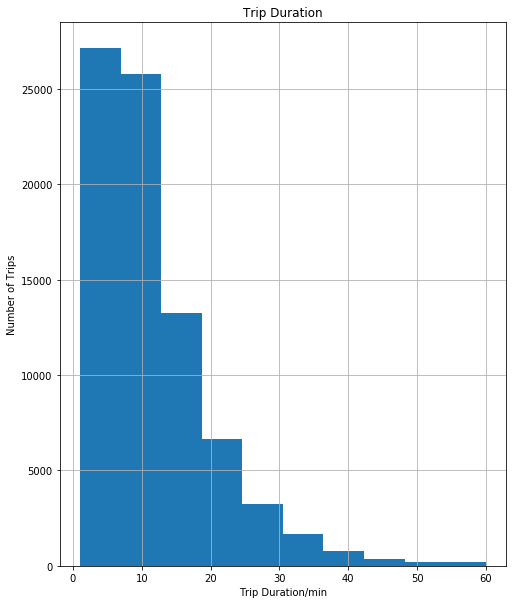

In [155]:
formatted_durations = list(a[0] for a in session.query(tripdata.tripduration).all())
formatted_durations_min = list(a / 60 for a in formatted_durations)
print('a. Mean Trip Duration: ' + str(statistics.mean(formatted_durations_min)))
print('b. Median Trip Duration: ' + str(statistics.median(formatted_durations_min)))
formatted_durations_in1h_min = list(a for a in formatted_durations_min if a <= 60)
plt.title('Trip Duration')
plt.xlabel('Trip Duration/min')
plt.ylabel('Number of Trips')
plt.grid(True)
hist = plt.hist(formatted_durations_in1h_min)

d. That's because of most of the people will take bikes for shorter duration around 9 minutes while there are still many people using for duration far greater than 20 min.

## Question 4

a. Mean Age: 34.946275445529785
Median Age: 31
b. Youngest: 17
Oldest: 131


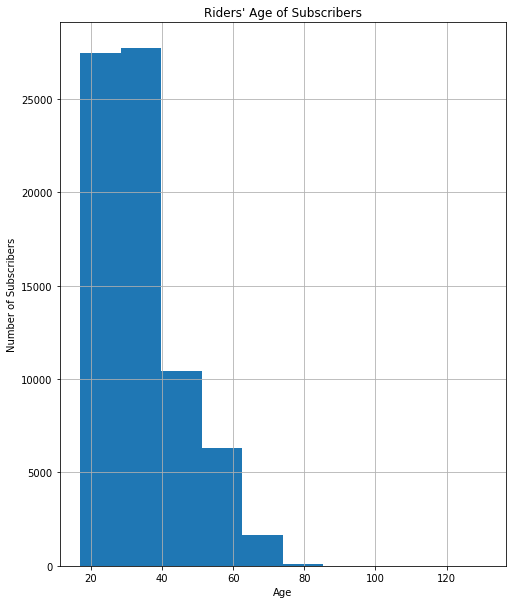

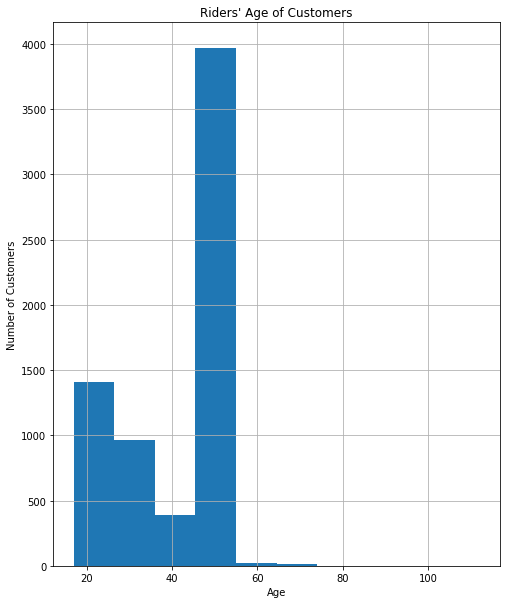

In [154]:
ages = list(2019 - a[0] for a in session.query(tripdata.birth_year).all())
print("a. Mean Age: " + str(statistics.mean(ages)))
print("Median Age: " + str(int(statistics.median(ages))))
print("b. Youngest: " + str(min(ages)))
print("Oldest: " + str(max(ages)))

ages_sub = list(2019 - a[0] for a in session.query(tripdata.birth_year).filter(tripdata.usertype == "Subscriber").all())
ages_cus = list(2019 - a[0] for a in session.query(tripdata.birth_year).filter(tripdata.usertype == "Customer").all())

plt.xlabel('Age')
plt.ylabel('Number of Subscribers')
plt.hist(ages_sub, rwidth=5)
plt.title('Riders\' Age of Subscribers')
plt.grid(True)
plt.show()

plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.hist(ages_cus, rwidth=5)
plt.title('Riders\' Age of Customers')
plt.grid(True)
plt.show()

d. Most subsribers are around 20-40 years old while customers are often around 50 years old. That might be because of people of higher ages will not subscribe a plan since they don't need to ride a lot and without a plan might become cheaper for them. However, younger people might rely more on riding, so a plan will save money.

## Question 5

In [7]:
start_station_ids = list(a[0] for a in session.query(tripdata.start_station_id).all())
count = {}
for sid in start_station_ids:
    if sid in count:
        count[sid] += 1
    else:
        count[sid] = 1
top5 = sorted(count.items(), key=lambda item: item[1], reverse = True)[0:5]
top5_wname = []
for idx, val in enumerate(top5):
    top5_wname.append([session.query(station.station_name).filter(station.id == val[0]).first()[0] ,top5[idx][1]])
for a in top5_wname:
    print("Name: " + a[0] + "\nNumber: " + str(a[1]) + "\n")

Name: MIT at Mass Ave / Amherst St
Number: 2766

Name: MIT Stata Center at Vassar St / Main St
Number: 2363

Name: Central Square at Mass Ave / Essex St
Number: 1960

Name: Kendall T
Number: 1864

Name: South Station - 700 Atlantic Ave
Number: 1755



In [8]:
routes = []
routes_count = {}
for a in session.query(tripdata).all():
    routes.append(str(a.start_station_id) + '-' + str(a.end_station_id))
for route in routes:
    if route in routes_count:
        routes_count[route] += 1
    else:
        routes_count[route] = 1
ordered_routes = sorted(routes_count.items(), key=lambda item: item[1], reverse = True)[0]
start, end = ordered_routes[0].split('-')
print("Most Popular Route: from " + session.query(station.station_name).filter(station.id == int(start)).first()[0] + " to " + session.query(station.station_name).filter(station.id == int(end)).first()[0])

Most Popular Route: from MIT Pacific St at Purrington St to MIT Stata Center at Vassar St / Main St


## Question 6

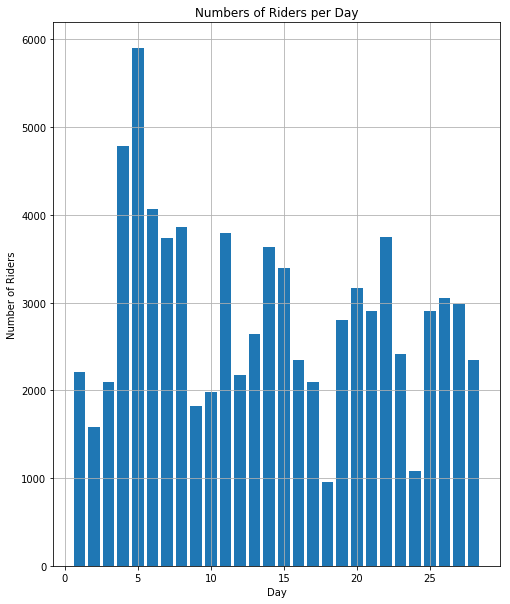

In [156]:
day_count = {}
trips = list(list(t.split(' ')[0].split('-')[2] for t in a) for a in session.query(tripdata.starttime, tripdata.stoptime).all())
for trip in trips:
    if int(trip[0]) not in day_count:
        day_count[int(trip[0])] = 1
    else:
        day_count[int(trip[0])] += 1
plt.bar(list(a for a in range(1,29)), list(day_count[a] for a in range(1,29)))
plt.xlabel('Day')
plt.ylabel('Number of Riders')
plt.title('Numbers of Riders per Day')
plt.grid(True)
plt.show()


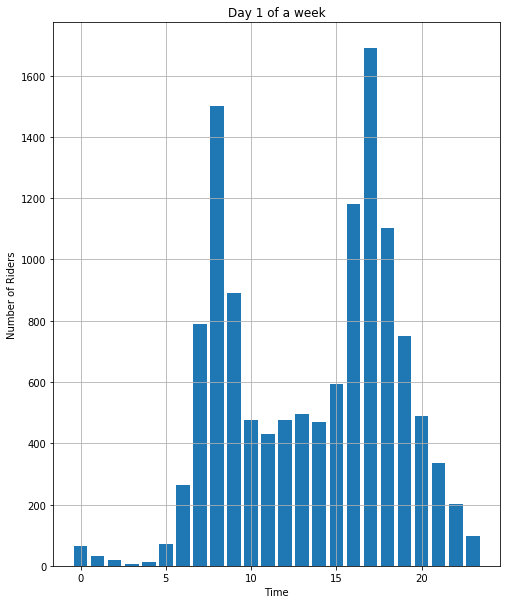

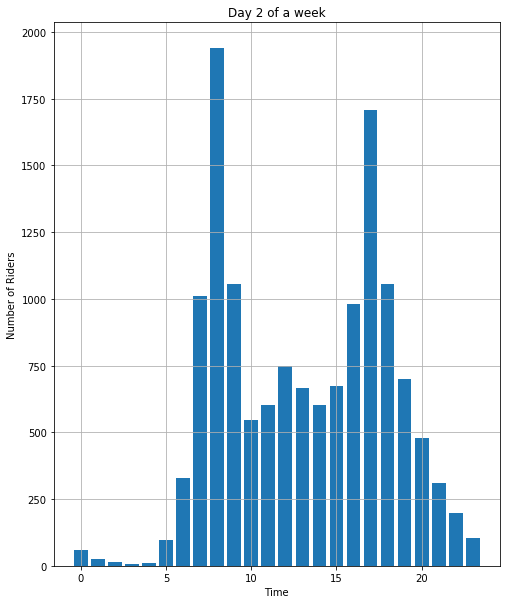

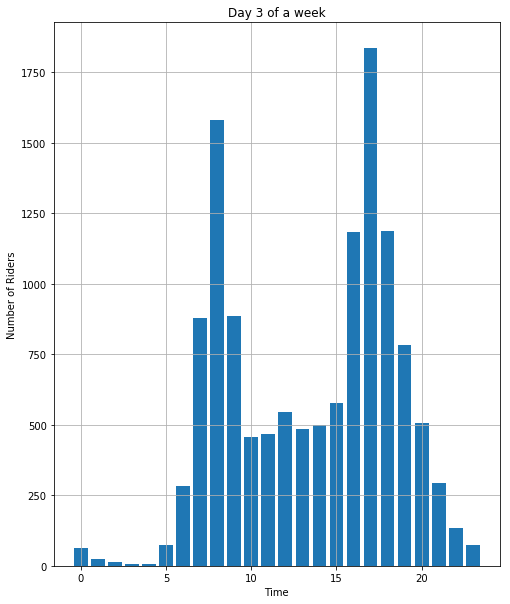

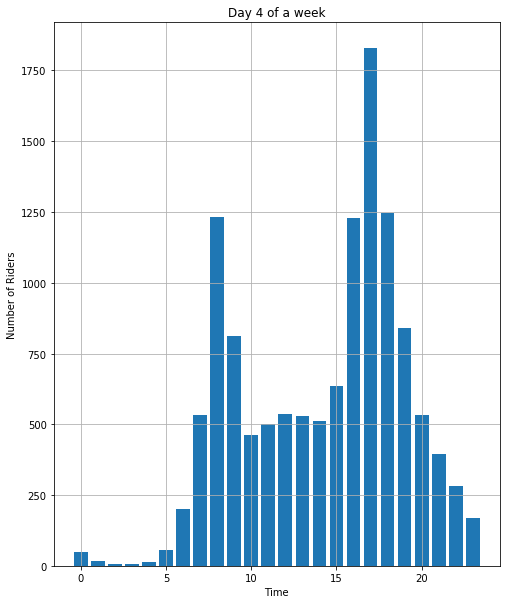

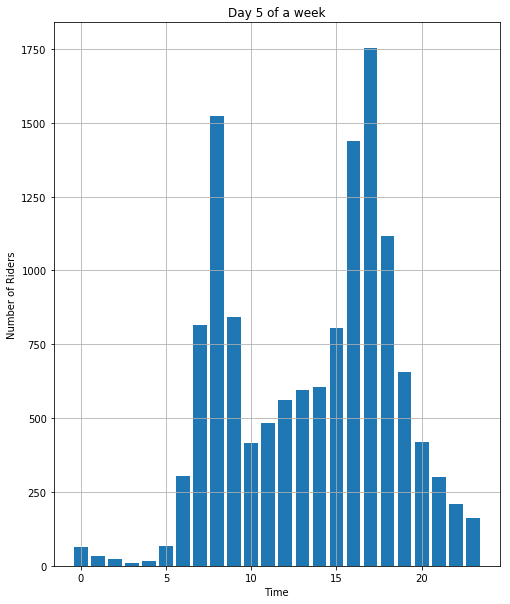

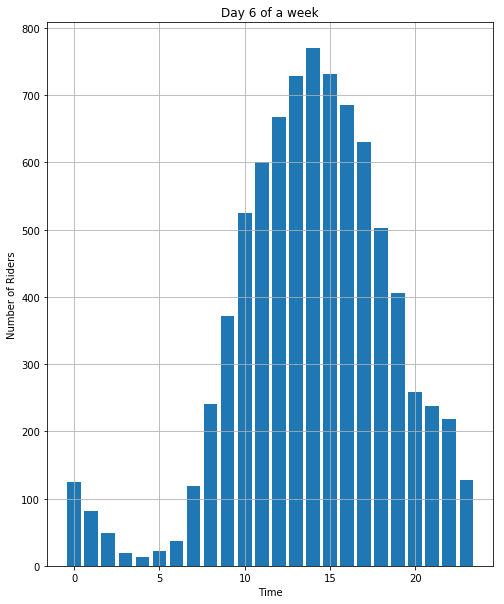

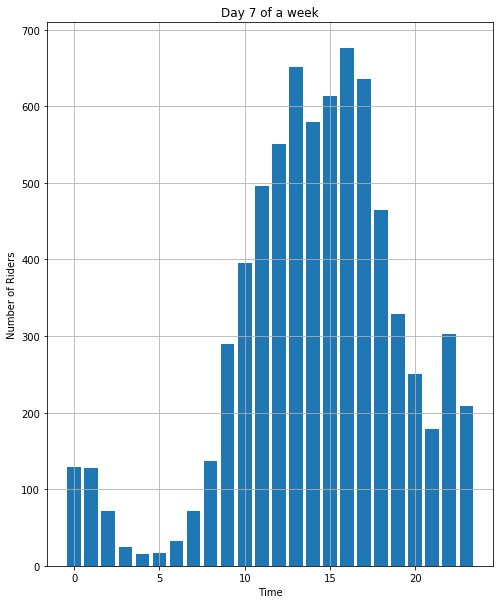

In [153]:
week_hour_count = {a: {a: 0 for a in range(0,24)} for a in range(0,7)}
trips = list(list(n for n in a[0].split(' ')) for a in session.query(tripdata.starttime).all())

for trip in trips:
    today = datetime.datetime(2019,2,int(trip[0].split('-')[2])).weekday()
    week_hour_count[today][int(trip[1].split(':')[0])] += 1
    
for d in week_hour_count:
    each_hour = []
    for t in week_hour_count[d]:
        each_hour.append(week_hour_count[d][t])
    plt.bar(list(a for a in range(0,24)), each_hour)
    plt.xlabel('Time')
    plt.ylabel('Number of Riders')
    plt.grid(True)
    plt.title('Day ' + str(d+1) + ' of a week')
    plt.show()
    


## Question 7

In [11]:
trips = list(int(a[0] / 60) for a in session.query(tripdata.tripduration).filter(tripdata.tripduration <= 60*60*2).all())
tR = 0
for a in trips:
    tR += int(a / 30) * 2.5
print('Total Revenue is $' + str(int(tR)))

Total Revenue is $12450


## Question 8

In [12]:
MS = len(list(a[0] for a in session.query(tripdata.id).filter(tripdata.gender == 1).filter(tripdata.usertype == 'Subscriber').all()))
MC = len(list(a[0] for a in session.query(tripdata.id).filter(tripdata.gender == 1).filter(tripdata.usertype == 'Customer').all()))
FS = len(list(a[0] for a in session.query(tripdata.id).filter(tripdata.gender == 2).filter(tripdata.usertype == 'Subscriber').all()))
FC = len(list(a[0] for a in session.query(tripdata.id).filter(tripdata.gender == 2).filter(tripdata.usertype == 'Customer').all()))


pandas.DataFrame([[MS,MC],[FS,FC]], ['Male', 'Female'], ['Subscribers', 'Customers'])

,Subscribers,Customers
Male,57321,2220
Female,15708,681


## Question 9

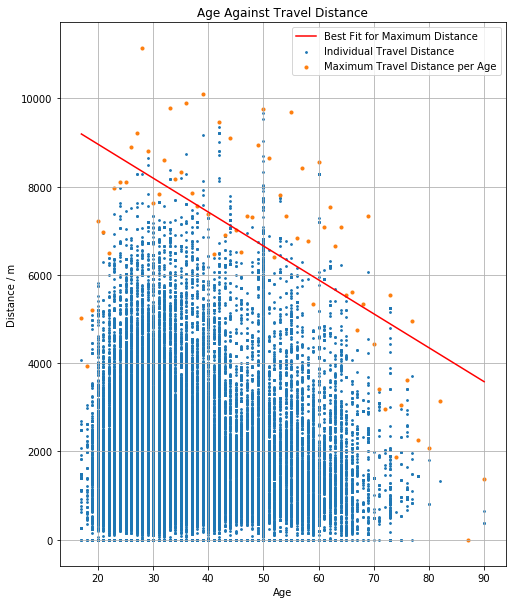

In [152]:
ages_start_end_station = list([2019 - a[0], a[1], a[2]]
                              for a in session.query(tripdata.birth_year,
                                                     tripdata.start_station_id,
                                                     tripdata.end_station_id).filter(tripdata.birth_year >= 2019 - 90).all())
stations = {a[0]: [a[1], a[2]] for a in session.query(station.id,
                                                      station.longitude,
                                                      station.latitude).all()}
age = []
length = []

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r * 1000

for a in ages_start_end_station:
    age.append(a[0])
    length.append(haversine(stations[a[1]][0], stations[a[1]][1], stations[a[2]][0], stations[a[2]][1]))

age_maximum = {}
for a in list([age[n], length[n]] for n in range(len(age))):
    if a[0] not in age_maximum or a[1] > age_maximum[a[0]]:
        age_maximum[a[0]] = a[1]

area = np.pi*1
plt.scatter(age, length, s=area, label='Individual Travel Distance')
plt.scatter(list(a for a in age_maximum), list(age_maximum[a] for a in age_maximum), s=area*3, label='Maximum Travel Distance per Age')
plt.plot(np.unique(list(a for a in age_maximum)), np.poly1d(np.polyfit(list(a for a in age_maximum), list(age_maximum[a] for a in age_maximum), 1))(np.unique(list(a for a in age_maximum))), label='Best Fit for Maximum Distance', color='red')
plt.xlabel('Age')
plt.ylabel('Distance / m')
plt.title('Age Against Travel Distance')
plt.rcParams['figure.figsize'] = [8,  10]
plt.legend()
plt.grid(True)
plt.show()
